<img width="300" src="https://cdn.cnn.com/cnnnext/dam/assets/210810173434-4-pan-am-707-economy-meals-credit-anne-sweeney-full-169.jpg" align='left'>

# Predicting the satisfaction level

In [1]:
import pandas as pd
import numpy as np
import yaml
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
from sys import path
from os.path import abspath

path.insert(0, abspath('../src'))
import mylib.cleaning as clean
import mylib.exploring as explore
import mylib.evaluating as evaluate
import mylib.transform as transform

In [3]:
pd.options.display.max_columns = None

#### Load config

In [4]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

#### Read cleaned data

In [5]:
data = pd.read_csv(config['data']['clean'])
data.head(2)

,id,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfied
0,70172,M,Loyal,13,Private,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,False
1,5047,M,Disloyal,25,Business,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,False


#### X/y Split

In [6]:
X = data.drop(['id', 'satisfied'], axis=1)
y = data['satisfied']

#### Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=config['testsplit']['test_size'],
                                                    random_state=config['testsplit']['random_state'])

#### Apply PowerTransformer, StandardScaler and OneHotEncoder

In [8]:
X_train, X_test = transform.scale_and_encode(X_train, X_test)

### Dealing with imbalance in the dependent column
I compared SMOTE with RandomOverSampler and got slightly better results on oversampling. This is why I decided to use the RandomOversampler instead of SMOTE.

In [9]:
ros = RandomOverSampler(random_state=1337)

print(f'Before oversampling:\n{y_train.value_counts()}')
X_train, y_train = ros.fit_resample(X_train, y_train)
print(f'After oversampling:\n{y_train.value_counts()}')

Before oversampling:
False    54854
True     42261
Name: satisfied, dtype: int64
After oversampling:
False    54854
True     54854
Name: satisfied, dtype: int64


#### Store transformed and balanced data

In [10]:
pd.concat([X_train, y_train], axis=1).to_csv(config['data']['train'], index=False)
pd.concat([X_test, y_test.reset_index()], axis=1).to_csv(config['data']['test'], index=False)

#### Get best features

In [11]:
explore.get_best_features(X_train, y_train)

,score,feature
0,17035.970397,type_of_travel_Private
1,13252.304077,class_Eco
2,4145.241672,online_boarding
3,2336.805015,inflight_entertainment
4,1961.211198,seat_comfort
5,1521.291701,on_board_service
6,1374.950972,leg_room_service
7,1282.738746,cleanliness
8,1245.584947,baggage_handling
9,1184.824266,class_Eco Plus


### Logistic Regression

#### We figured out the best parameters for the LogisticRegressor using GridSearch. 
<pre>
params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'random_state': [1337],
    'multi_class': ['multinomial', 'auto', 'ovr'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [None, 300]
}

model = LogisticRegression(solver='lbfgs',
                  multi_class='multinomial')
gs = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=3)
gs.fit(X_train, y_train)
</pre>

#### This gave us the following results:<br>
Best params: {'max_iter': 300, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1337, 'solver': 'sag'}<br>
Accuracy: 0.872944624477064


{'max_iter': 300, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 1337, 'solver': 'sag'}<br>
Accuracy: 0.872944624477064


#### Train and fit LogisticRegressor

In [12]:
logReg = LogisticRegression(max_iter=300, multi_class='multinomial',
                          penalty='l2', random_state=1337,
                          solver='sag')
logReg.fit(X_train, y_train)

LogisticRegression(max_iter=300, multi_class='multinomial', random_state=1337,
                   solver='sag')

#### Save model

In [13]:
with open(config['model']['logReg'], 'wb') as file:
    pickle.dump(logReg, file)

#### Evaluate model for training set

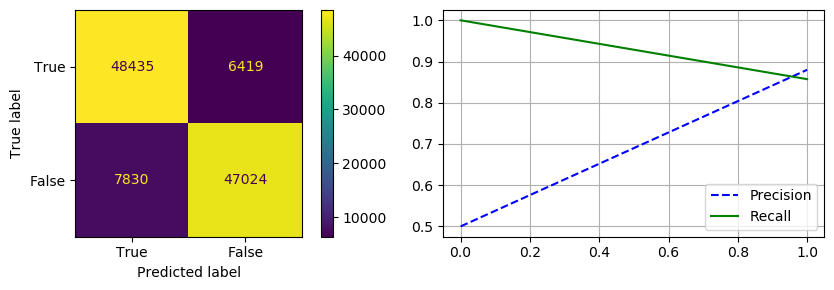

              precision    recall  f1-score   support

       False       0.86      0.88      0.87     54854
        True       0.88      0.86      0.87     54854

    accuracy                           0.87    109708
   macro avg       0.87      0.87      0.87    109708
weighted avg       0.87      0.87      0.87    109708




In [14]:
y_train_pred = logReg.predict(X_train)
evaluate.print_classification_results(logReg, y_train, y_train_pred)

#### Evaluate model for testset

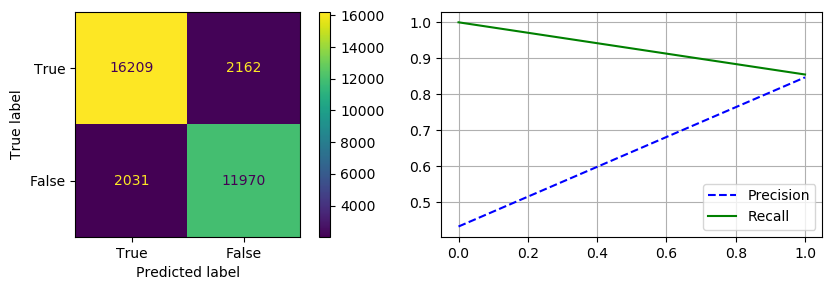

              precision    recall  f1-score   support

       False       0.89      0.88      0.89     18371
        True       0.85      0.85      0.85     14001

    accuracy                           0.87     32372
   macro avg       0.87      0.87      0.87     32372
weighted avg       0.87      0.87      0.87     32372




In [15]:
y_test_pred  = logReg.predict(X_test)
evaluate.print_classification_results(logReg, y_test, y_test_pred)

### Check RandomForestClassifier

#### We figured out the best parameters for the RandomForestClassifier using GridSearch. 

<pre>
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,4]
}

gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=params, cv=5, verbose=3)
gs.fit(X_train, y_train)
</pre>

#### This gave us the following results:
Best params: {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2}<br>
Train: 0.9642324606409286<br>
Test: 0.9530768491250419


#### Fitting the model

In [16]:
randForest = RandomForestClassifier(criterion='entropy',
                               min_samples_leaf=2,
                               min_samples_split=2)
randForest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2)

#### Save model

In [17]:
with open(config['model']['randForest'], 'wb') as file:
    pickle.dump(randForest, file)

#### Evaluate model for training set

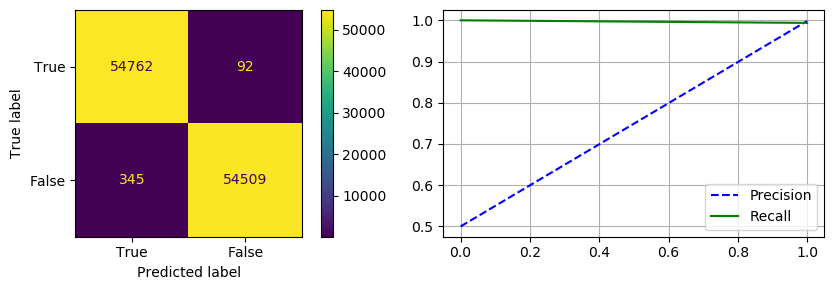

              precision    recall  f1-score   support

       False       0.99      1.00      1.00     54854
        True       1.00      0.99      1.00     54854

    accuracy                           1.00    109708
   macro avg       1.00      1.00      1.00    109708
weighted avg       1.00      1.00      1.00    109708




In [18]:
y_train_pred = randForest.predict(X_train)
evaluate.print_classification_results(randForest, y_train, y_train_pred)

#### Evaluate model for testset

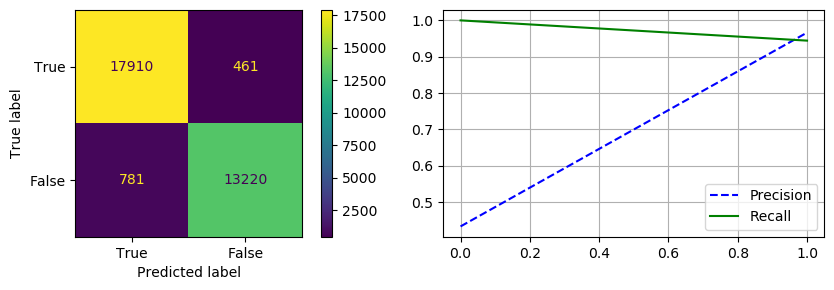

              precision    recall  f1-score   support

       False       0.96      0.97      0.97     18371
        True       0.97      0.94      0.96     14001

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372




In [29]:
y_test_pred  = randForest.predict(X_test)
evaluate.print_classification_results(randForest, y_test, y_test_pred)

In [30]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_test_pred)

0.9216297084409751

### Check KNeighborsClassifier

#### We figured out the best parameters for the KNeighborsClassifier using GridSearch.

<pre>
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, verbose=3)
gs.fit(X_train, y_train)
</pre>

#### This gave us the following results:
Best parmas: {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}<br>
Train: 0.9391842000882116<br>
Test: 0.9137833997111106

In [20]:
knn = KNeighborsClassifier(n_neighbors=8,
                             weights='distance',
                             algorithm='auto')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8, weights='distance')

#### Save model

In [21]:
with open(config['model']['knn'], 'wb') as file:
    pickle.dump(knn, file)

#### Evaluate model for training set

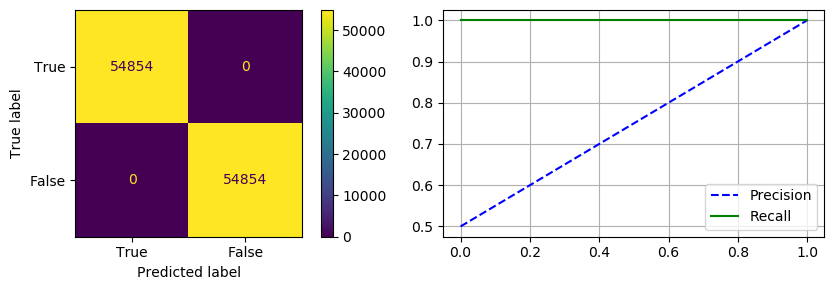

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     54854
        True       1.00      1.00      1.00     54854

    accuracy                           1.00    109708
   macro avg       1.00      1.00      1.00    109708
weighted avg       1.00      1.00      1.00    109708




In [22]:
y_train_pred = knn.predict(X_train)
evaluate.print_classification_results(knn, y_train, y_train_pred)

#### Evaluate model for testset

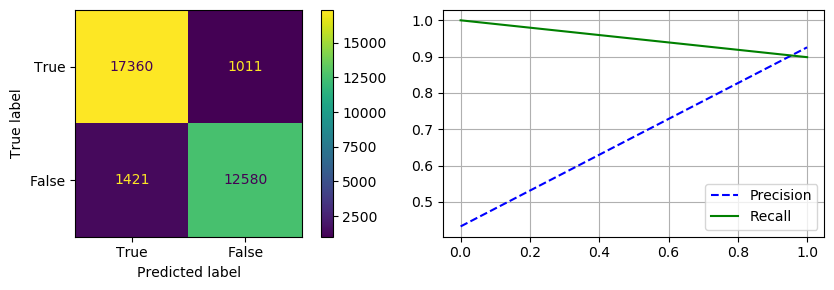

              precision    recall  f1-score   support

       False       0.92      0.94      0.93     18371
        True       0.93      0.90      0.91     14001

    accuracy                           0.92     32372
   macro avg       0.92      0.92      0.92     32372
weighted avg       0.92      0.92      0.92     32372




In [23]:
y_test_pred  = knn.predict(X_test)
evaluate.print_classification_results(knn, y_test, y_test_pred)

### Comparing models

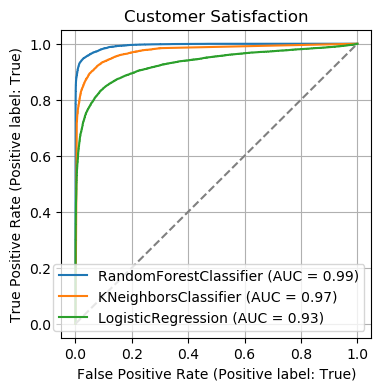

In [24]:
from sklearn.metrics import plot_roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig,ax = plt.subplots(figsize=(4,4))
plot_roc_curve(randForest, X_test, y_test, ax=ax)
plot_roc_curve(knn, X_test, y_test, ax=ax)
plot_roc_curve(logReg, X_test, y_test, ax=ax)
plt.plot([0,1], [0,1], linestyle='dashed', color='grey')
ax.grid()
ax.set_title('Customer Satisfaction')

plt.savefig('../plots/roc_curves_satisfaction.png', dpi=300)
plt.show()

### As we can see, RandomForestClassifier performes best!